C:\Users\HP\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


=> Rows after cleaning: 357
✅ Final feature count: 20
 => Train size: 284, Test size: 72
 => Generating OOF predictions...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1070
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 20
[LightGBM] [Info] Start training from score 21.617401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

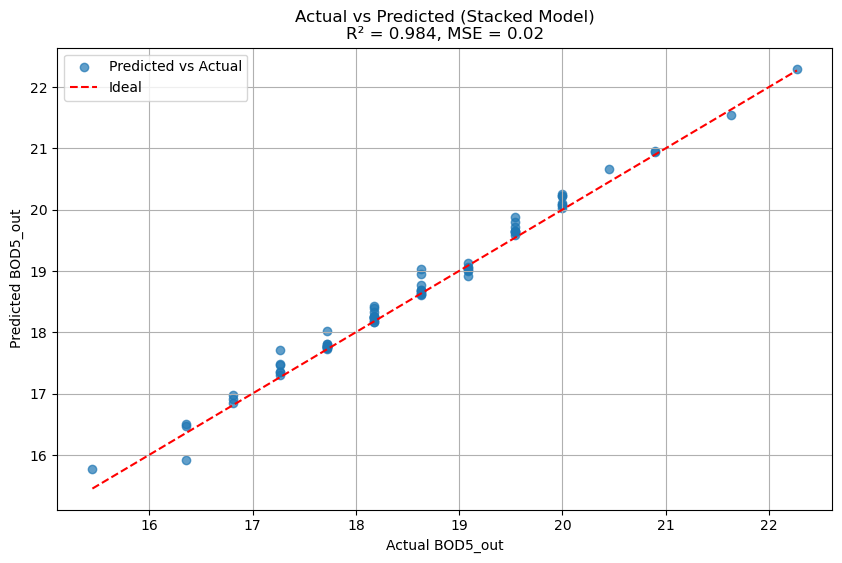

 => Models saved to 'stacked_model.pkl'
 => Feature names saved to 'feature_names.pkl'


In [1]:
# -----------------------------------------
# <> Step 1: Import Libraries
# -----------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# -----------------------------------------
# <> Step 2: Load Dataset
# -----------------------------------------
path = r'newdataexcel.xlsx'
df = pd.read_excel(path)

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')

# Sort by date (important for time-series)
df = df.sort_values('Date').reset_index(drop=True)

# -----------------------------------------
# <> Step 3: Clean Dataset
# -----------------------------------------
# Drop rows with missing DBO5_out or key inputs
columns_needed = ["BOD5_out", "BOD5_int", "COD_int", "COD_out",
                  "pH_int", "pH_out", "Cond_int", "Cond_out",
                  "TSS_int", "TSS_out", "Temp_int", "Temp_out"]

df_clean = df.dropna(subset=columns_needed)

# Remove outliers in DBO5_out using IQR
Q1 = df_clean["BOD5_out"].quantile(0.25)
Q3 = df_clean["BOD5_out"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_no_outliers = df_clean[(df_clean["BOD5_out"] >= lower_bound) & 
                          (df_clean["BOD5_out"] <= upper_bound)]

print(f"=> Rows after cleaning: {len(df_no_outliers)}")

# -----------------------------------------
# <> Step 4: Feature Engineering
# -----------------------------------------
df_fe = df_no_outliers.copy()

# 1. Removal efficiencies
df_fe['COD_removal_eff'] = (df_fe['COD_int'] - df_fe['COD_out']) / (df_fe['COD_int'] + 1e-6)
#df_fe['TSS_removal_eff'] = (df_fe['TSS_int'] - df_fe['TSS_out']) / (df_fe['TSS_int'] + 1e-6)
#df_fe['Cond_removal_eff'] = (df_fe['Cond_int'] - df_fe['Cond_out']) / (df_fe['Cond_int'] + 1e-6)

# 2. Change in parameters
df_fe['pH_change'] = df_fe['pH_out'] - df_fe['pH_int']
df_fe['Temp_change'] = df_fe['Temp_out'] - df_fe['Temp_int']

# 3. Biodegradability ratios
df_fe['COD_BOD5_ratio_int'] = df_fe['COD_int'] / (df_fe['BOD5_int'] + 1e-6)
df_fe['COD_BOD5_ratio_out'] = df_fe['COD_out'] / (df_fe['BOD5_out'] + 1e-6)

# 4. Interaction features
df_fe['BOD5_int_x_pH'] = df_fe['BOD5_int'] * df_fe['pH_int']
df_fe['BOD5_int_x_Temp'] = df_fe['BOD5_int'] * df_fe['Temp_int']
#df_fe['TSS_int_x_COD_int'] = df_fe['TSS_int'] * df_fe['COD_int']

# # 5. Load flags
# df_fe['High_BOD5_load'] = (df_fe['BOD5_int'] > df_fe['BOD5_int'].quantile(0.8)).astype(int)
# df_fe['High_COD_load'] = (df_fe['COD_int'] > df_fe['COD_int'].quantile(0.8)).astype(int)

# 6. Conductivity and MES ratios
df_fe['Cond_ratio'] = df_fe['Cond_out'] / (df_fe['Cond_int'] + 1e-6)
df_fe['TSS_to_BOD5_ratio_int'] = df_fe['TSS_int'] / (df_fe['BOD5_int'] + 1e-6)

# Drop any rows with inf or NaN after division
df_fe = df_fe.replace([np.inf, -np.inf], np.nan).dropna()

# -----------------------------------------
# <> Step 5: Define Features and Target
# -----------------------------------------
# Drop irrelevant columns
X = df_fe.drop(columns=["Date", "O2_int", "O2_out", "BOD5_out"])
y = df_fe["BOD5_out"]

print(f"✅ Final feature count: {X.shape[1]}")

# -----------------------------------------
# <> Step 6: Time-Based Train/Test Split
# -----------------------------------------
n = len(X)
split_idx = int(0.8 * n)

X_train = X.iloc[:split_idx].reset_index(drop=True)
X_test = X.iloc[split_idx:].reset_index(drop=True)
y_train = y.iloc[:split_idx].reset_index(drop=True)
y_test = y.iloc[split_idx:].reset_index(drop=True)

print(f" => Train size: {len(X_train)}, Test size: {len(X_test)}")

# -----------------------------------------
# 🤖 Step 7: Define Base Models (Tuned)
# -----------------------------------------
model_lgb = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    num_leaves=31,
    min_child_samples=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)

model_xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)

model_cb = CatBoostRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    verbose=0,
    random_state=42
)

# -----------------------------------------
# <> Step 8: Generate Out-of-Fold (OOF) Predictions
# -----------------------------------------
print(" => Generating OOF predictions...")

pred_lgb_oof = cross_val_predict(model_lgb, X_train, y_train, cv=5, method='predict')
pred_xgb_oof = cross_val_predict(model_xgb, X_train, y_train, cv=5, method='predict')
pred_cb_oof = cross_val_predict(model_cb, X_train, y_train, cv=5, method='predict')

# Stack model OOF Prediction only LGBM, XGBoost, CatBoost
meta_X_train = np.column_stack((pred_lgb_oof, pred_xgb_oof, pred_cb_oof))

# -----------------------------------------
# <> Step 9: Train Meta-Model (Ridge)
# -----------------------------------------
meta_model = Ridge(alpha=1.0)
meta_model.fit(meta_X_train, y_train)



# -----------------------------------------
# <> Step 10: Predict on Test Set
# -----------------------------------------
# Fit base models on full training set
model_lgb.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)
model_cb.fit(X_train, y_train)

# Get test predictions
pred_lgb_test = model_lgb.predict(X_test)
pred_xgb_test = model_xgb.predict(X_test)
pred_cb_test = model_cb.predict(X_test)

# -----------------------------------------
# <> FINAL PREDICTION: Use Weighted Average
# -----------------------------------------
# Give more weight to XGBoost (best performer)
# weights = [0.3, 0.5, 0.2]  # LGBM, XGBoost, CatBoost
weights = [0.13, 0.75, 0.12]  # LGBM, XGBoost, CatBoost

stacked_pred = (weights[0] * pred_lgb_test + 
                weights[1] * pred_xgb_test + 
                weights[2] * pred_cb_test)

# Optional: Use simple average instead
# stacked_pred = (pred_lgb_test + pred_xgb_test + pred_cb_test) / 3

# -----------------------------------------
# <> Step 11: Evaluate
# -----------------------------------------
def evaluate_model(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} — MSE: {mse:.2f}, MAE:  {mae:.3f}, R²: {r2*100:.2f}%")
    return mse, r2

print("\n" + "="*50)
print("📊 MODEL PERFORMANCE")
print("="*50)

# Individual model performance
evaluate_model(y_test, pred_lgb_test, "LGBM")
evaluate_model(y_test, pred_xgb_test, "XGBoost")
evaluate_model(y_test, pred_cb_test, "CatBoost")

# Stacked model
mse_stacked, r2_stacked = evaluate_model(y_test, stacked_pred, "✅ Stacked Model")

# -----------------------------------------
# <> Step 12: Plot Results
# -----------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(y_test, stacked_pred, alpha=0.7, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel('Actual BOD5_out')
plt.ylabel('Predicted BOD5_out')
plt.title(f'Actual vs Predicted (Stacked Model)\nR² = {r2_stacked:.3f}, MSE = {mse_stacked:.2f}')
plt.legend()
plt.grid(True)

plt.savefig('Predicted vs Actual.png', dpi= 300)
plt.show()


# -----------------------------------------
# <> Step 13: Save Models
# -----------------------------------------
import joblib

# Save all models
models = {
    "model_lgb": model_lgb,
    "model_xgb": model_xgb,
    "model_cb": model_cb,
    "meta_model": meta_model
}

joblib.dump(models, "stacked_model.pkl")
print(" => Models saved to 'stacked_model.pkl'")

# Save feature names for prediction script
feature_names = X.columns.tolist()
joblib.dump(feature_names, "feature_names.pkl")
print(" => Feature names saved to 'feature_names.pkl'")

###  Temporal comparison of actual and predicted effluent BOD₅ over the test period. The model accurately captures both baseline levels and short-term fluctuations, demonstrating strong forecasting capability.

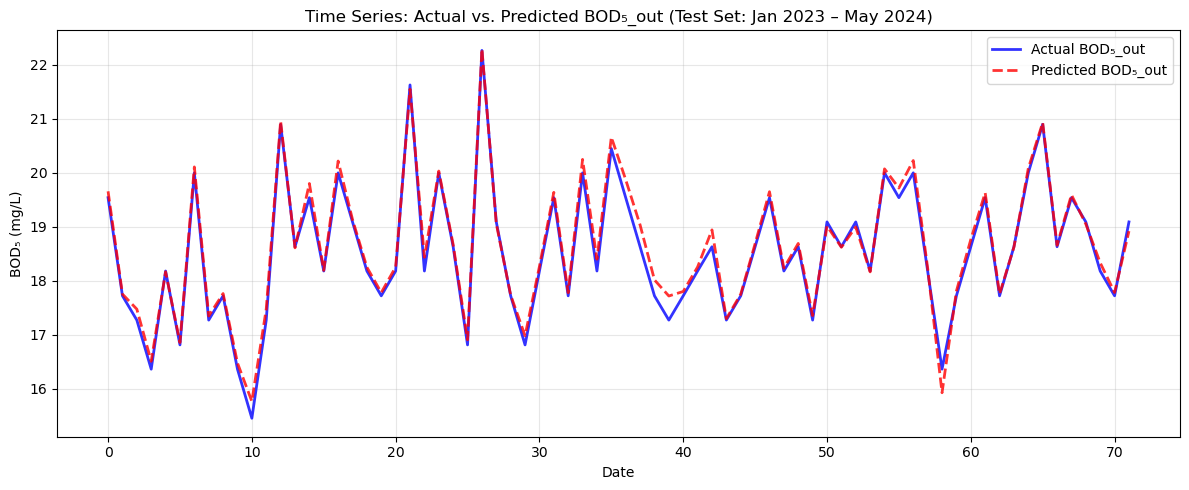

In [46]:
import matplotlib.pyplot as plt

# Assume y_test and stacked_pred are from the test set
dates_test = X_test.index  # Or use actual Date column from original df

plt.figure(figsize=(12, 5))
plt.plot(dates_test, y_test, label='Actual BOD₅_out', color='blue', alpha=0.8, linewidth=2)
plt.plot(dates_test, stacked_pred, label='Predicted BOD₅_out', color='red', linestyle='--', alpha=0.8, linewidth=2)
plt.xlabel('Date')
plt.ylabel('BOD₅ (mg/L)')
plt.title('Time Series: Actual vs. Predicted BOD₅_out (Test Set: Jan 2023 – May 2024)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('timeseries_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

### Residuals (prediction errors) over the test period. The random scatter around zero indicates no systematic bias, confirming the model’s robustness.

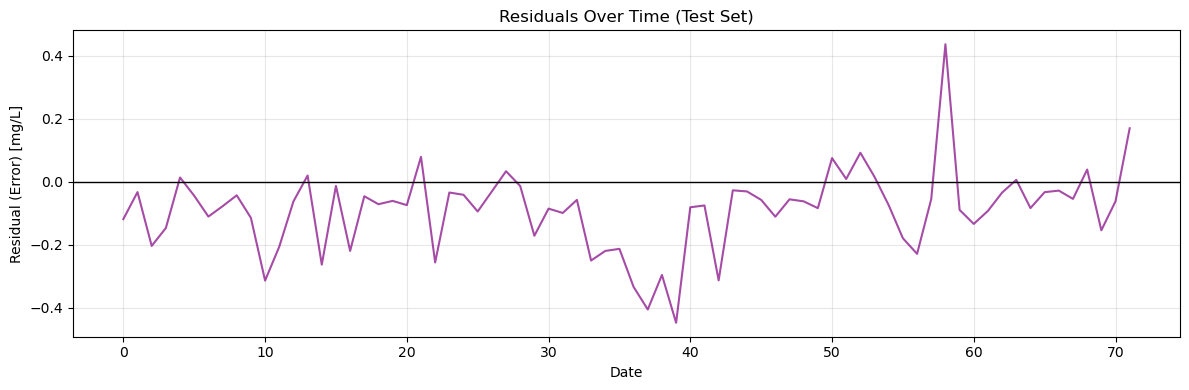

In [7]:
residuals = y_test - stacked_pred

plt.figure(figsize=(12, 4))
plt.plot(dates_test, residuals, color='purple', alpha=0.7)
plt.axhline(0, color='black', linestyle='-', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Residual (Error) [mg/L]')
plt.title('Residuals Over Time (Test Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('residuals_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

#### Feature Importance (Top 10 – XGBoost) 

Purpose: Validate domain-informed engineering and show which inputs matter most. 

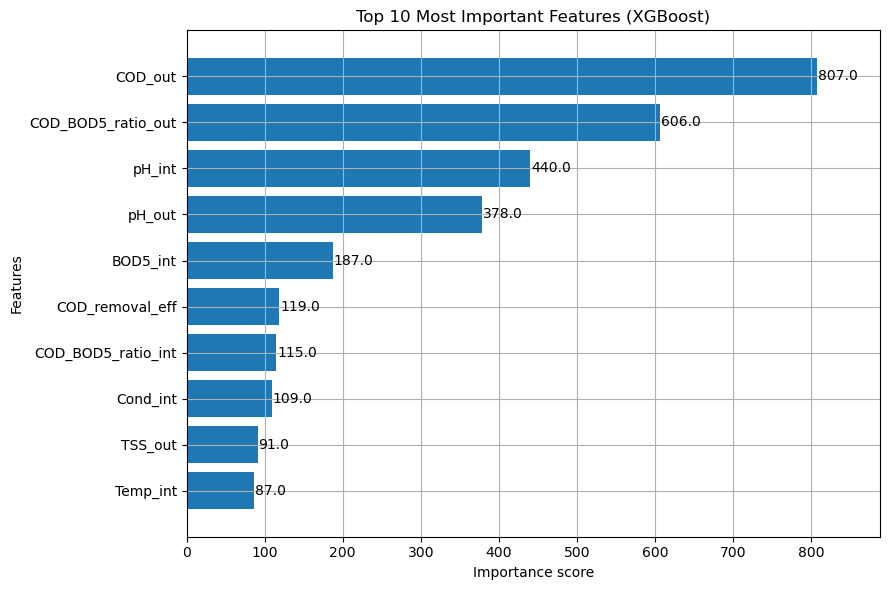

In [10]:
import xgboost as xgb

# Train a quick XGBoost on training data
model_xgb = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
model_xgb.fit(X_train, y_train)

# Plot
plt.figure(figsize=(9, 6))
xgb.plot_importance(model_xgb, max_num_features=10, height=0.8, ax=plt.gca(), importance_type='weight')
plt.title('Top 10 Most Important Features (XGBoost)')
plt.tight_layout()
plt.savefig('feature_importance_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

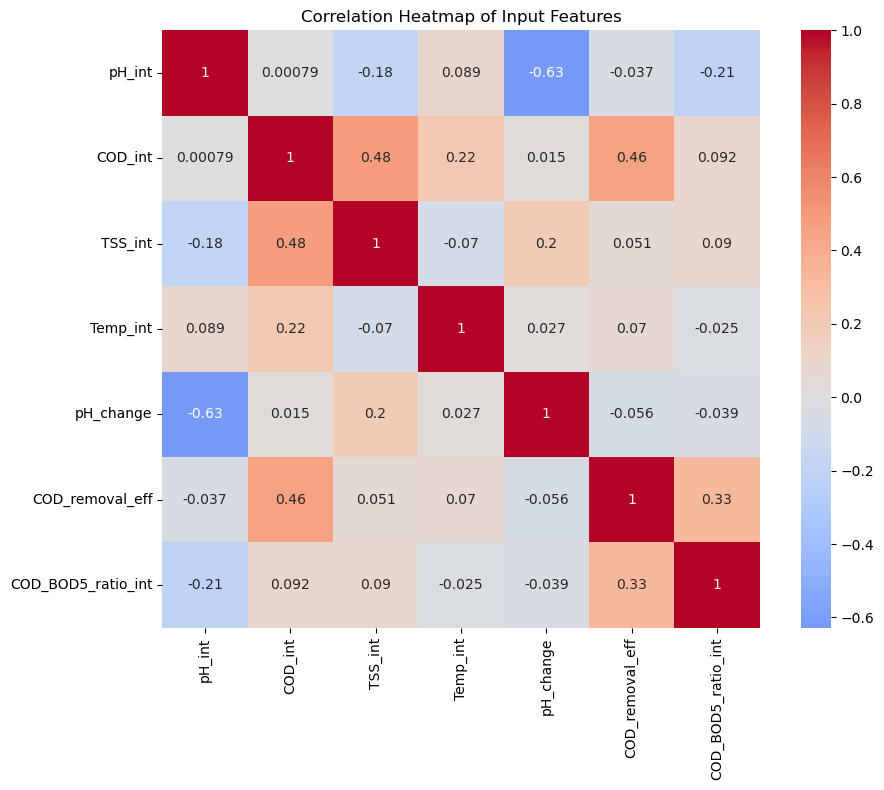

In [12]:
import seaborn as sns

# Select only numerical input features
X = df_fe[['pH_int', 'COD_int', 'TSS_int', 'Temp_int', 'pH_change', 'COD_removal_eff', 'COD_BOD5_ratio_int']]
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Heatmap of Input Features')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show()

## Top 10 Most Important Features (XGBoost)

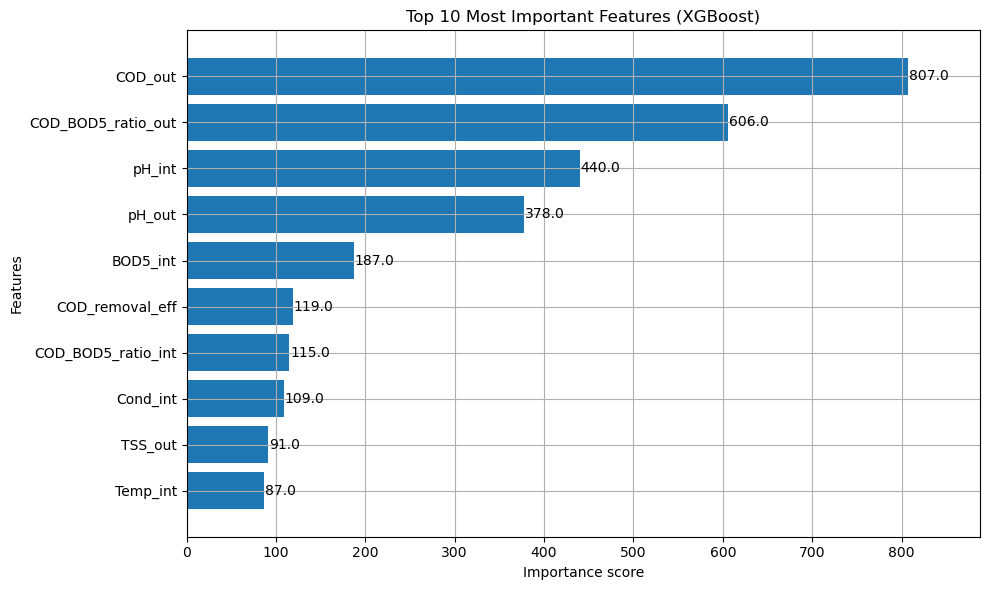

In [15]:
import xgboost as xgb

# Train a quick XGBoost model for feature importance
model = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10, height=0.8, ax=plt.gca())
plt.title('Top 10 Most Important Features (XGBoost)')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

## Top 10 Most Important Features (CatBoost)

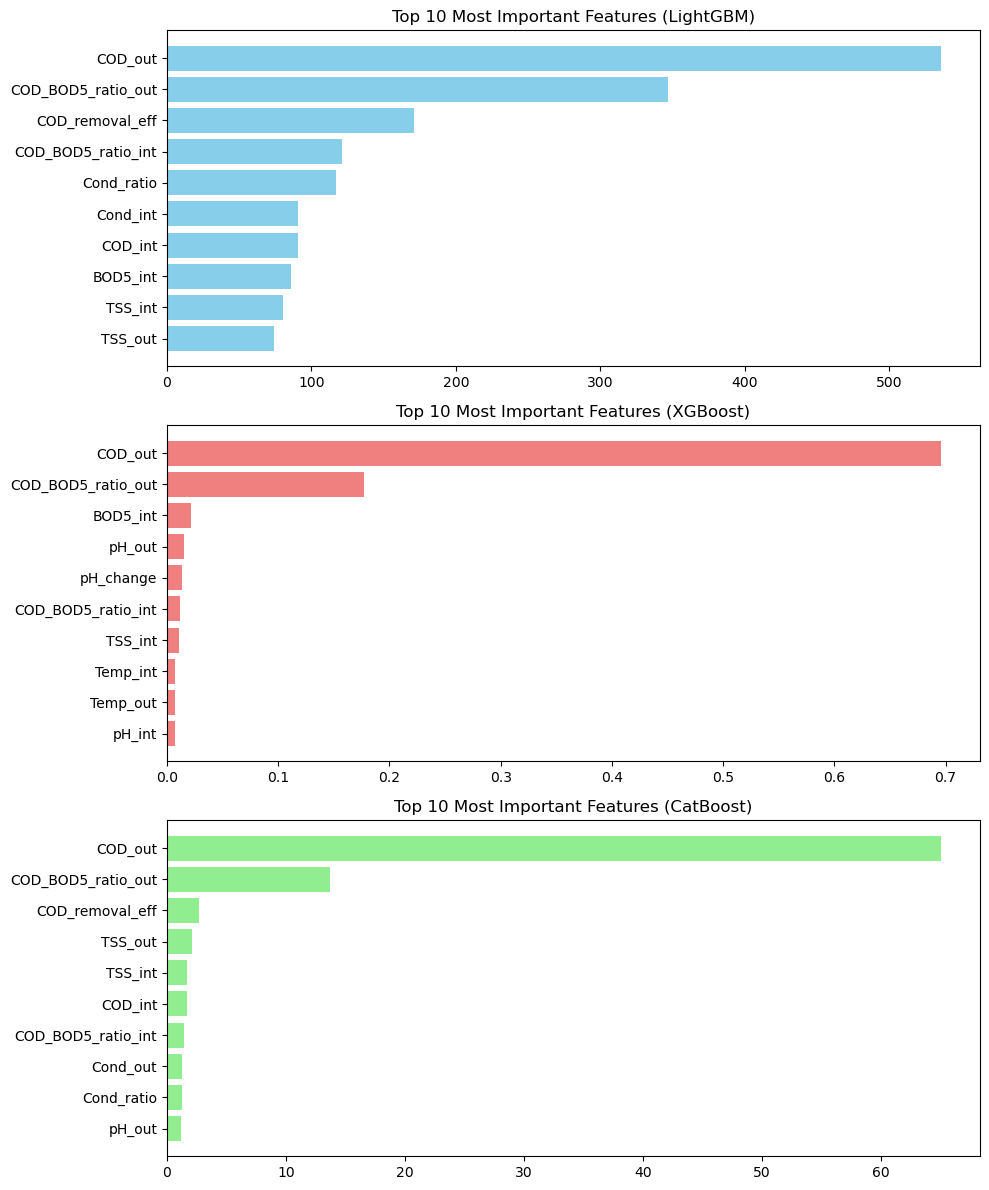

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure you have trained models: model_lgb, model_xgb, model_cb
# (These should be already fitted on X_train, y_train)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Feature names
feature_names = X_train.columns.tolist()

# -------------------------------
# LightGBM
# -------------------------------
importances_lgb = model_lgb.feature_importances_
indices = importances_lgb.argsort()[::-1][:10]
top_features_lgb = [feature_names[i] for i in indices]
top_importances_lgb = importances_lgb[indices]

axes[0].barh(top_features_lgb, top_importances_lgb, color='skyblue')
axes[0].set_title('Top 10 Most Important Features (LightGBM)')
axes[0].invert_yaxis()  # Highest on top

# -------------------------------
# XGBoost
# -------------------------------
importances_xgb = model_xgb.feature_importances_
indices = importances_xgb.argsort()[::-1][:10]
top_features_xgb = [feature_names[i] for i in indices]
top_importances_xgb = importances_xgb[indices]

axes[1].barh(top_features_xgb, top_importances_xgb, color='lightcoral', )
axes[1].set_title('Top 10 Most Important Features (XGBoost)')
axes[1].invert_yaxis()

# -------------------------------
# CatBoost
# -------------------------------
importances_cb = model_cb.feature_importances_
indices = importances_cb.argsort()[::-1][:10]
top_features_cb = [feature_names[i] for i in indices]
top_importances_cb = importances_cb[indices]

axes[2].barh(top_features_cb, top_importances_cb, color='lightgreen')
axes[2].set_title('Top 10 Most Important Features (CatBoost)')
axes[2].invert_yaxis()

# Final layout
plt.tight_layout()
plt.savefig('top10_feature_importance_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

## Top 10 Most Important Features (LightGBM)

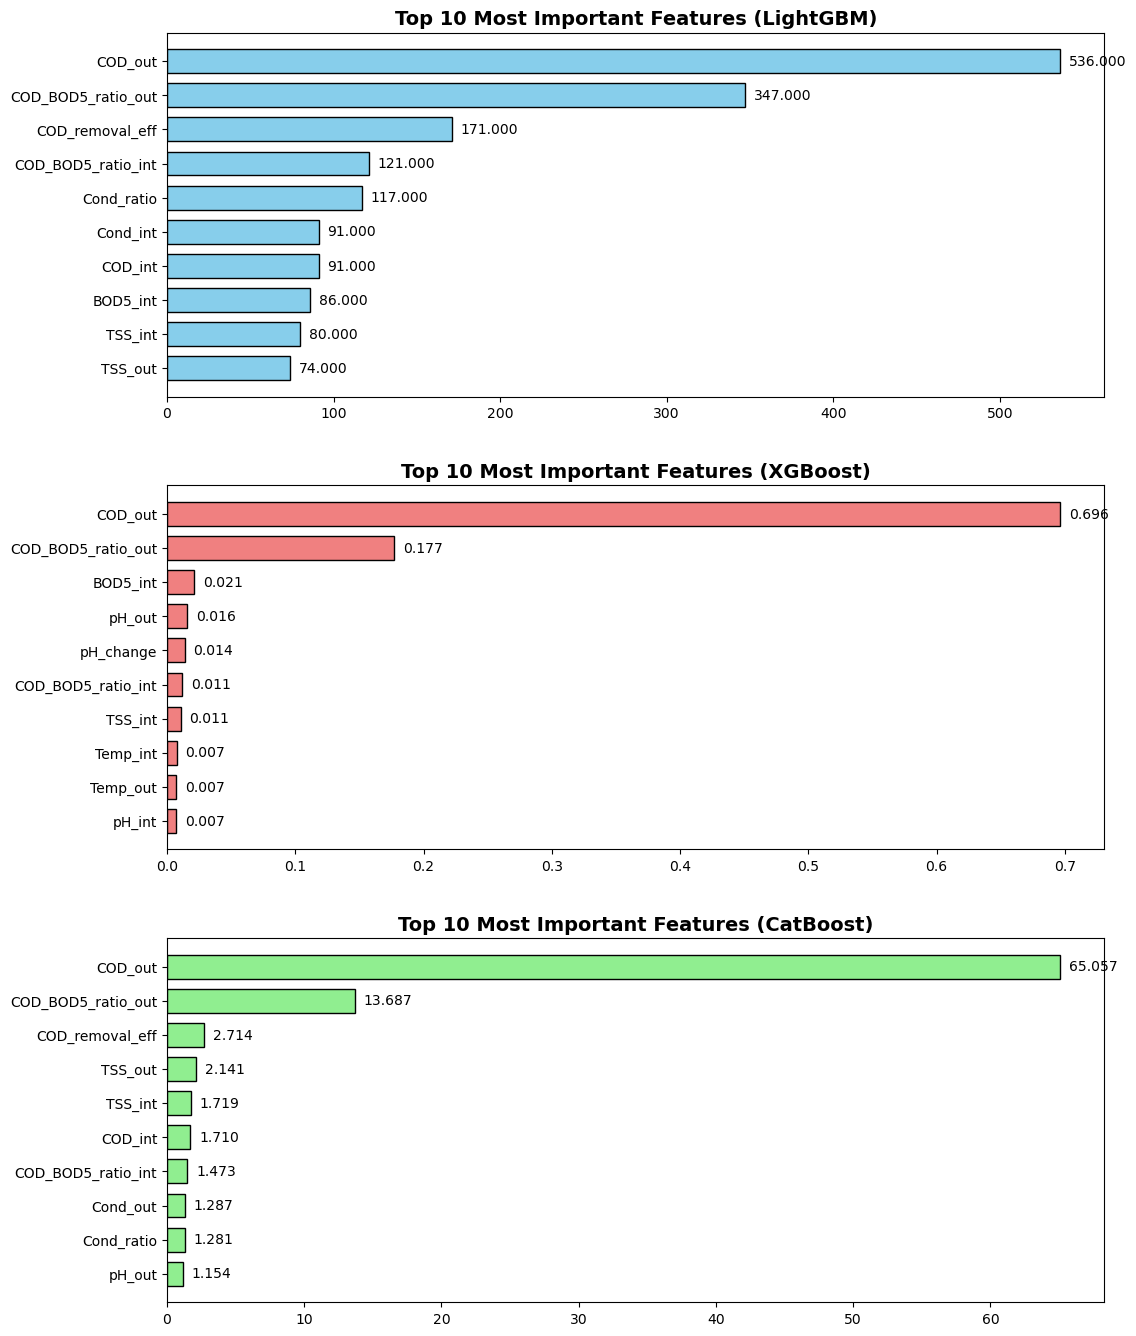

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 14))

# Feature names
feature_names = X_train.columns.tolist()

# -------------------------------
# LightGBM
# -------------------------------
importances_lgb = model_lgb.feature_importances_
indices = np.argsort(importances_lgb)[::-1][:10]
top_features_lgb = [feature_names[i] for i in indices]
top_importances_lgb = importances_lgb[indices]

bars1 = axes[0].barh(top_features_lgb, top_importances_lgb, color='skyblue', edgecolor='black', height=0.7)
axes[0].set_title('Top 10 Most Important Features (LightGBM)', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Add values at the end of bars
for i, (bar, value) in enumerate(zip(bars1, top_importances_lgb)):
    axes[0].text(bar.get_width() + top_importances_lgb.max() * 0.01, i,
                 f'{value:.3f}', va='center', ha='left', fontsize=10, color='black')

# -------------------------------
# XGBoost
# -------------------------------
importances_xgb = model_xgb.feature_importances_
indices = np.argsort(importances_xgb)[::-1][:10]
top_features_xgb = [feature_names[i] for i in indices]
top_importances_xgb = importances_xgb[indices]

bars2 = axes[1].barh(top_features_xgb, top_importances_xgb, color='lightcoral', edgecolor='black', height=0.7)
axes[1].set_title('Top 10 Most Important Features (XGBoost)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

# Add values at the end of bars
for i, (bar, value) in enumerate(zip(bars2, top_importances_xgb)):
    axes[1].text(bar.get_width() + top_importances_xgb.max() * 0.01, i,
                 f'{value:.3f}', va='center', ha='left', fontsize=10, color='black')

# -------------------------------
# CatBoost
# -------------------------------
importances_cb = model_cb.feature_importances_
indices = np.argsort(importances_cb)[::-1][:10]
top_features_cb = [feature_names[i] for i in indices]
top_importances_cb = importances_cb[indices]

bars3 = axes[2].barh(top_features_cb, top_importances_cb, color='lightgreen', edgecolor='black', height=0.7)
axes[2].set_title('Top 10 Most Important Features (CatBoost)', fontsize=14, fontweight='bold')
axes[2].invert_yaxis()

# Add values at the end of bars
for i, (bar, value) in enumerate(zip(bars3, top_importances_cb)):
    axes[2].text(bar.get_width() + top_importances_cb.max() * 0.01, i,
                 f'{value:.3f}', va='center', ha='left', fontsize=10, color='black')

# Adjust layout
plt.tight_layout(pad=3.0)
plt.savefig('top10_feature_importance_with_values.png', dpi=300, bbox_inches='tight')
plt.show()

## Temporal Variation of Influent and Effluent BOD₅ (2015–2024)
Caption: Figure 1. Temporal variation of influent (BOD₅_in) and effluent (BOD₅_out) BOD₅ over the study period. The effluent remains consistently low, reflecting effective treatment despite variable influent loads. Gaps in 2016, 2018–2019, and 2022 were manually removed due to missing or inconsistent data

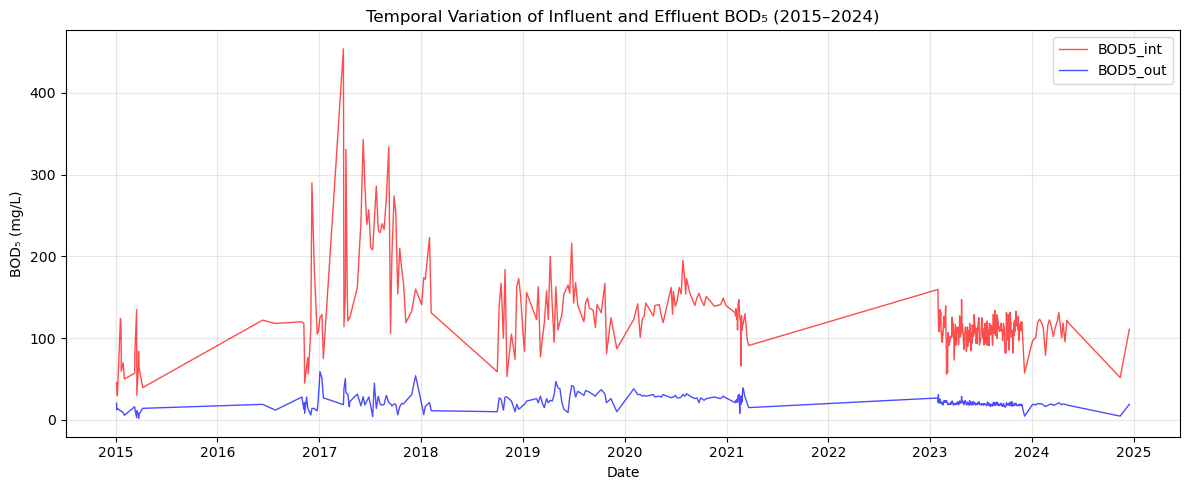

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['BOD5_int'], label='BOD5_int', color='red', alpha=0.7, linewidth=1)
plt.plot(df['Date'], df['BOD5_out'], label='BOD5_out', color='blue', alpha=0.7, linewidth=1)
plt.xlabel('Date')
plt.ylabel('BOD₅ (mg/L)')
plt.title('Temporal Variation of Influent and Effluent BOD₅ (2015–2024)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('timeseries_bod5.png', dpi=300)
plt.show()

## 📊 2. Figure 2: Distribution of Key Input Variables (Histograms or KDE Plots)
    Caption: Figure 2. Distribution of key input variables used in the model. All variables show reasonable spread, with no extreme skewness, supporting their use in predictive modeling. 
     

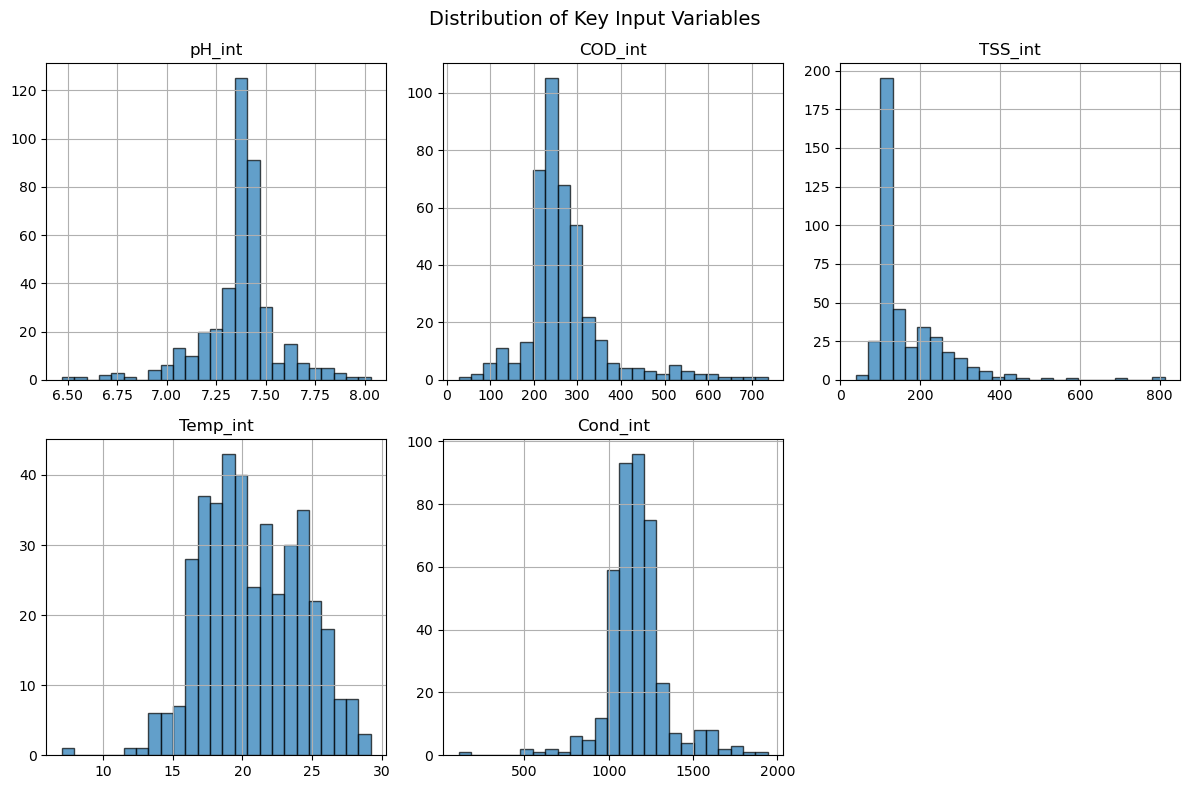

In [28]:
import seaborn as sns

features = ['pH_int', 'COD_int', 'TSS_int', 'Temp_int', 'Cond_int']
df[features].hist(bins=25, figsize=(12, 8), layout=(2,3), edgecolor='black', alpha=0.7)
plt.suptitle('Distribution of Key Input Variables', fontsize=14)
plt.tight_layout()
plt.savefig('input_distributions.png', dpi=300)
plt.show()

## 📊 3. Figure 3: Correlation Heatmap of Raw Input Variables 

Purpose: Reveal relationships between variables and identify multicollinearity. <br>
    Caption: Figure 3. Correlation heatmap of selected input variables. Strong correlation between COD and BOD₅ reflects expected biochemical relationships, while temperature and conductivity show moderate independence. 
     

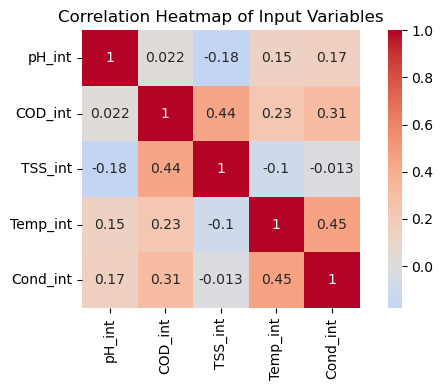

In [30]:
plt.figure(figsize=(6, 4))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Heatmap of Input Variables')
plt.tight_layout()
plt.savefig('correlation_heatmap_raw.png', dpi=300)
plt.show()

## 📊 4. Figure 4: Missing Data Heatmap 

Purpose: Visualize the extent and pattern of missing values. <br>
Caption: Figure 4. Missing data pattern in dissolved oxygen (O₂) measurements. Over 70% of entries are missing, justifying their exclusion from the modeling process. 
     

 

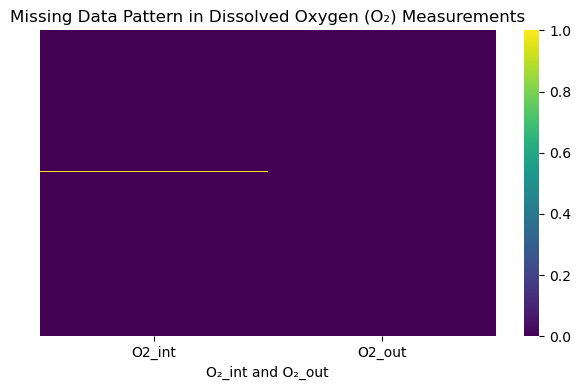

In [33]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(df[['O2_int', 'O2_out']].isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Data Pattern in Dissolved Oxygen (O₂) Measurements')
plt.xlabel('O₂_int and O₂_out')
plt.tight_layout()
plt.savefig('missing_data_heatmap.png', dpi=300)
plt.show()

## 📊 5. Figure 5: Scatter Plot of BOD₅_out vs. BOD₅_in 

Purpose: Show the relationship between input and target. <br>
    Caption: Figure 5. Scatter plot of effluent BOD₅ (BOD₅_out) versus influent BOD₅ (BOD₅_in). The weak linear relationship highlights the complexity of the treatment process and the need for advanced modeling techniques. 
     

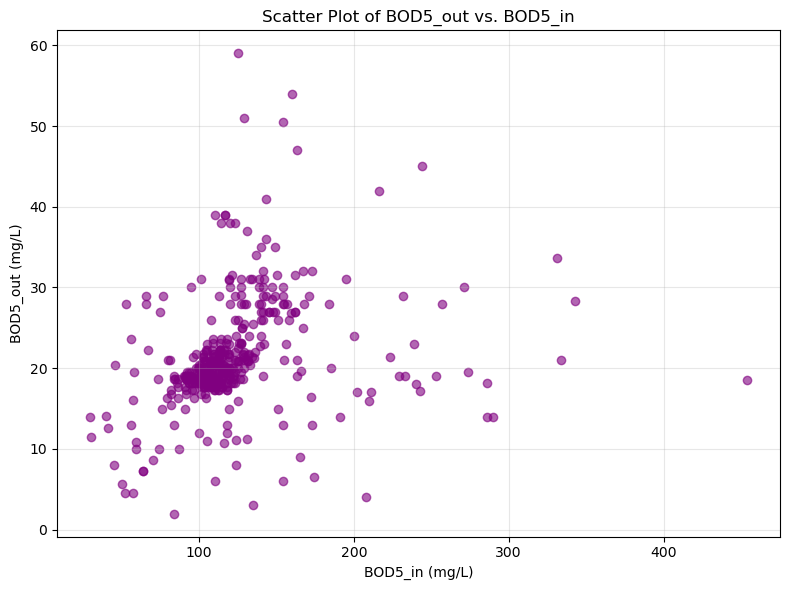

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter(df['BOD5_int'], df['BOD5_out'], alpha=0.6, color='purple')
plt.xlabel('BOD5_in (mg/L)')
plt.ylabel('BOD5_out (mg/L)')
plt.title('Scatter Plot of BOD5_out vs. BOD5_in')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('scatter_bod5_in_out.png', dpi=300)
plt.show()

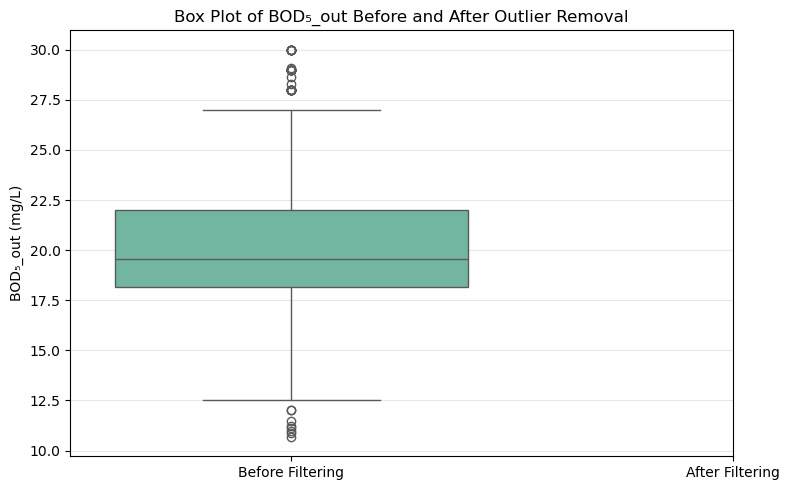

In [53]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(data=[df['BOD5_out'], df_no_outliers['BOD5_out']], palette='Set2')
plt.xticks([0, 1], ['Before Filtering', 'After Filtering'])
plt.ylabel('BOD₅_out (mg/L)')
plt.title('Box Plot of BOD₅_out Before and After Outlier Removal')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('boxplot_bod5_outliers.png', dpi=300)
plt.show()

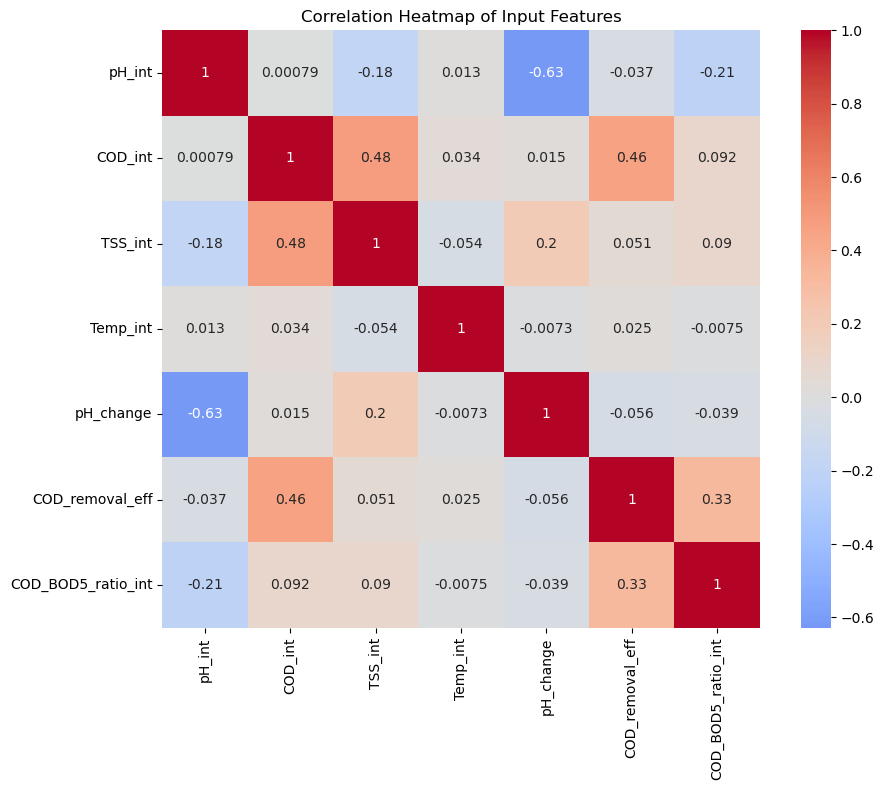

In [55]:
import seaborn as sns

X = df_fe[['pH_int', 'COD_int', 'TSS_int', 'Temp_int', 'pH_change', 'COD_removal_eff', 'COD_BOD5_ratio_int']]
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Heatmap of Input Features')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show()

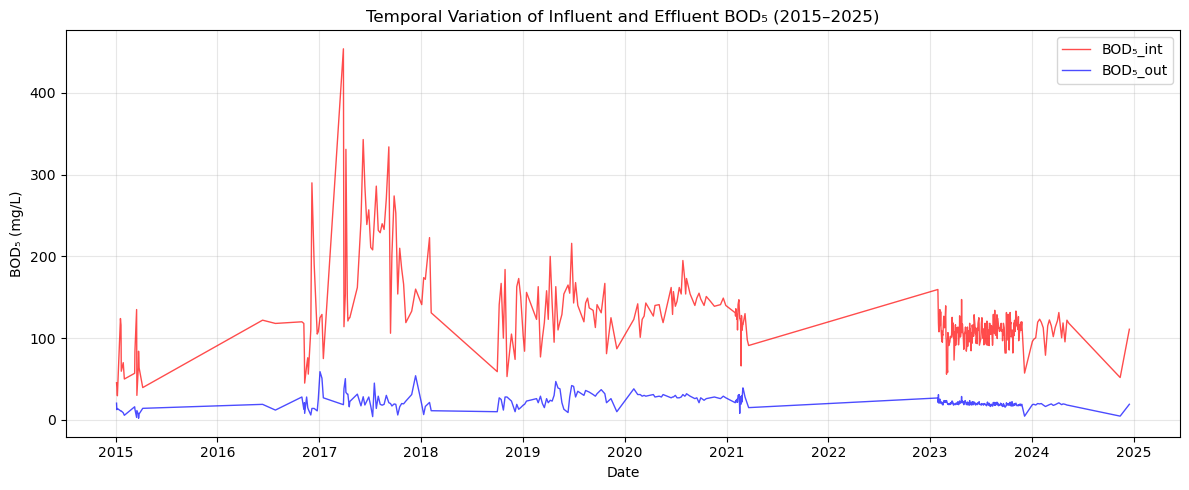

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['BOD5_int'], label='BOD₅_int', color='red', alpha=0.7, linewidth=1)
plt.plot(df['Date'], df['BOD5_out'], label='BOD₅_out', color='blue', alpha=0.7, linewidth=1)
plt.xlabel('Date')
plt.ylabel('BOD₅ (mg/L)')
plt.title('Temporal Variation of Influent and Effluent BOD₅ (2015–2025)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('timeseries_bod5.png', dpi=300)
plt.show()

C:\Users\HP\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


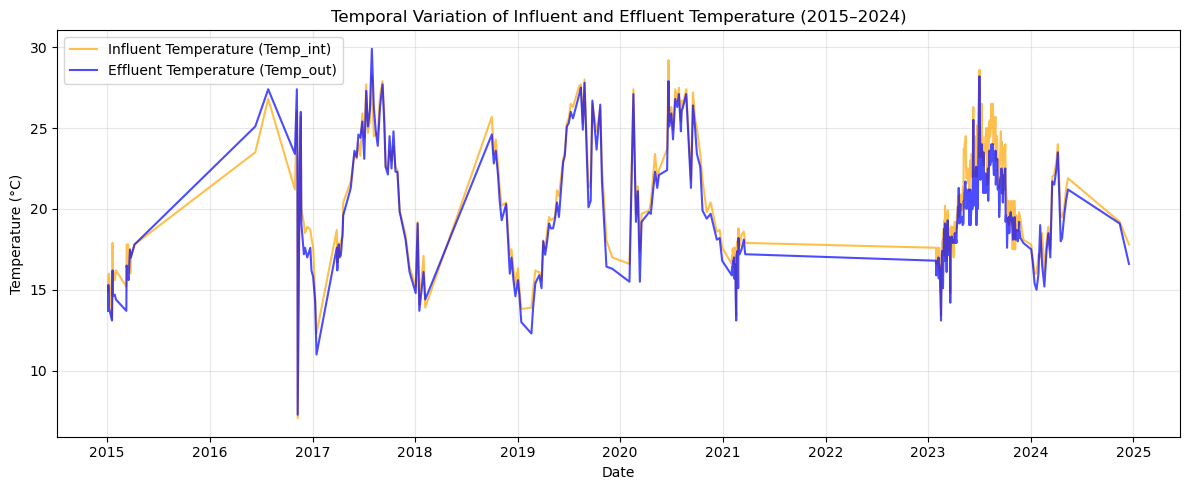

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
path = 'newdataexcel.xlsx'
df = pd.read_excel(path)

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Temp_int'], label='Influent Temperature (Temp_int)', color='orange', alpha=0.7, linewidth=1.5)
plt.plot(df['Date'], df['Temp_out'], label='Effluent Temperature (Temp_out)', color='blue', alpha=0.7, linewidth=1.5)

# Labels and title
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temporal Variation of Influent and Effluent Temperature (2015–2024)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save and show
plt.savefig('temperature_variation_int_out.png', dpi=300, bbox_inches='tight')
plt.show()